In [1]:
import numpy as np
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('using device:', device)

using device: cuda


In [2]:
import os
from typing import Tuple


def load_dataset(path: os.PathLike) -> Tuple[torch.Tensor, torch.Tensor]:
    X = np.load(os.path.join(path, 'inputs.npy'))
    T = np.load(os.path.join(path, 'targets.npy'))

    N = X.shape[0]
    X = X.reshape((N, 1, 256, 256)) # reshape to 1-channel for convolutions

    return torch.tensor(X, dtype=torch.float32), \
        torch.tensor(T, dtype=torch.long)

# X_train = torch.tensor(X, device=device, dtype=torch.float32)
# y_train = torch.tensor(T, device=device, dtype=torch.long)
X_train, y_train = load_dataset('model_train/train')

n_classes = int(y_train.max()) + 1
X_train.shape, y_train.shape, n_classes

(torch.Size([28800, 1, 256, 256]), torch.Size([28800]), 251)

In [3]:
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

from model import create_model

model = create_model(n_classes, device)

optim = AdamW(model.parameters(), lr=1e-5)
loss_fn = CrossEntropyLoss()

In [4]:
with torch.no_grad():
    o = model(X_train[:1].to(device))
    loss = loss_fn(o, y_train[:1].to(device))
    print(loss)

tensor(5.5153, device='cuda:0')


In [5]:
epochs     = 100
batch_size = 256

In [6]:
from model import train

t_l, v_l = train(model, epochs, X_train, y_train, optim, loss_fn, device, bs=batch_size)

Starting training.
Number of minibatches for training/test: 99/15
Starting epoch 1 of 100
	Training took: 221.10s
		with train loss: 4.873550
		with valid loss: 4.811495
Starting epoch 2 of 100
	Training took: 222.34s
		with train loss: 4.763146
		with valid loss: 4.735794
Starting epoch 3 of 100
	Training took: 220.99s
		with train loss: 4.624378
		with valid loss: 4.584090
Starting epoch 4 of 100
	Training took: 213.38s
		with train loss: 4.416194
		with valid loss: 4.367993
Starting epoch 5 of 100
	Training took: 211.95s
		with train loss: 4.177794
		with valid loss: 4.116960
Starting epoch 6 of 100
	Training took: 207.43s
		with train loss: 3.958912
		with valid loss: 3.895897
Starting epoch 7 of 100
	Training took: 207.43s
		with train loss: 3.767544
		with valid loss: 3.682522
Starting epoch 8 of 100
	Training took: 207.60s
		with train loss: 3.604837
		with valid loss: 3.541166
Starting epoch 9 of 100
	Training took: 207.67s
		with train loss: 3.466471
		with valid loss: 3.38704

In [7]:
np.save('train_losses_new.npy', t_l)
np.save('valid_losses_new.npy', v_l)

In [8]:
from typing import List


def load_losses(ckpt_path: os.PathLike) -> Tuple[List[float], List[float]]:
    n = len(list(filter(lambda f: f.endswith('.pt'), os.listdir(ckpt_path))))
    t_l = [0] * n
    v_l = [0] * n
    for f in os.listdir(ckpt_path):
        if not f.endswith('.pt'):
            continue
        ckpt = torch.load(os.path.join(ckpt_path, f))
        e = ckpt['epoch']
        t_l[e] = ckpt['train_loss']
        v_l[e] = ckpt['valid_loss']
    return t_l, v_l

In [11]:
ckpt_path = 'checkpoints/27-06-2024-10-23-10'
t_l, v_l = load_losses(ckpt_path)

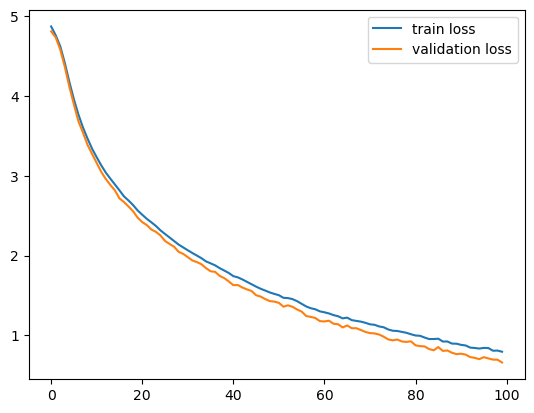

In [9]:
import matplotlib.pyplot as plt

n = len(t_l)

ax = plt.subplot()
ax.plot(np.arange(n), t_l, label='train loss')
ax.plot(np.arange(n), v_l, label='validation loss')
plt.legend()

In [ ]:
t_l1, v_l1 = load_losses('E:\\25-06-2024-13-35-11 (lr0.001)')
t_l2, v_l2 = load_losses('E:\\25-06-2024-15-26-10 (lr0.0001)')
N = min(len(t_l), len(t_l1), len(t_l2))

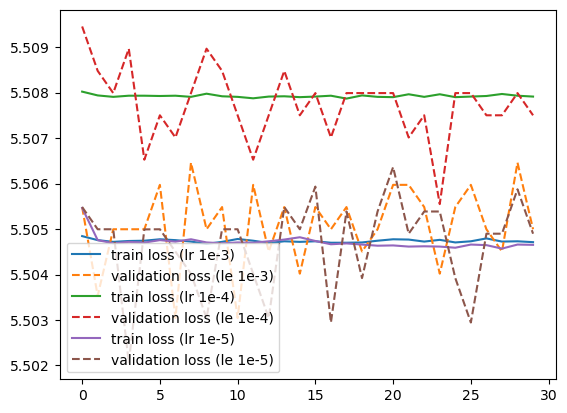

In [17]:
ax = plt.subplot()

ax.plot(np.arange(N), t_l1, label='train loss (lr 1e-3)')
ax.plot(np.arange(N), v_l1, label='validation loss (le 1e-3)', linestyle='dashed')
ax.plot(np.arange(N), t_l2, label='train loss (lr 1e-4)')
ax.plot(np.arange(N), v_l2, label='validation loss (le 1e-4)', linestyle='dashed')
ax.plot(np.arange(N), t_l[:N], label='train loss (lr 1e-5)')
ax.plot(np.arange(N), v_l[:N], label='validation loss (le 1e-5)', linestyle='dashed')
plt.legend()

In [10]:
from model import eval_acc, load_model_checkpoint

accs = [0] * 100
test_accs  = [0] * 100

ckpt_path = 'checkpoints/27-06-2024-10-23-10'

X_test, y_test = load_dataset('model_train/test')

model.eval()
for f in os.listdir(ckpt_path):
    if not f.endswith('.pt'):
        continue
    model_file = os.path.join(ckpt_path, f)
    ckpt = load_model_checkpoint(model_file, model, device=device)
    e = ckpt['epoch']
    # ckpt = torch.load(model_file, map_location='cuda')
    tr_acc = eval_acc(model, X_train, y_train, device, bs=batch_size)
    te_acc = eval_acc(model, X_test, y_test, device, bs=batch_size)
    accs[e] = tr_acc
    test_accs[e] = te_acc

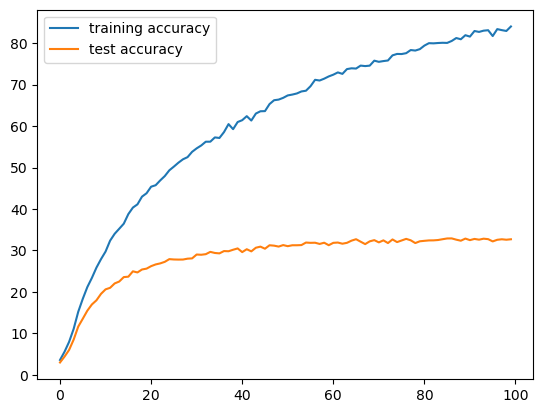

In [11]:
import matplotlib.pyplot as plt

np_accs = np.array(accs) * 100
np_test_accs = np.array(test_accs) * 100

ax = plt.subplot()
ax.plot(np.arange(len(accs)), np_accs, label='training accuracy')
ax.plot(np.arange(len(accs)), np_test_accs, label='test accuracy')
plt.legend()